# [실습1] Deep Q-Network 구현 실습 (정답)

이번 실습에서는 단순 Q-Learning으로는 대응할 수 없는, State가 매우 많은 시뮬레이션 환경에 Deep Q-Network를 구현 및 적용해보도록 하겠습니다.

### 라이브러리 불러오기

필요한 라이브러리를 불러옵니다.

In [1]:
# 필요한 라이브러리를 불러옵니다.
import gymnasium as gym
import numpy as np
import pandas as pd

# 학습을 완료한 에이전트를 시각화하는데 필요한 라이브러리를 불러옵니다
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Epsilon-Greedy 를 적용하기 위한 random 모듈을 불러옵니다.
import random

# 딥러닝 모델을 통해 Q-Network를 구현하기 위한 라이브러리를 불러옵니다.
import torch
import torch.nn as nn

from tqdm import tqdm

from collections import deque

/tmp/ipykernel_73/272604880.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


시뮬레이션 결과 시각화를 위한 함수를 정의합니다.

In [2]:
def visualize_render_queue(render_queue):
    fig = plt.figure()
    ims = []
    for i in range(len(render_queue)):
        im = plt.imshow(render_queue[i], animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                    repeat_delay=1000)
    
    return HTML(ani.to_jshtml())

## 1. CartPole 시뮬레이션 환경

마찰이 없는 선로에서 양옆으로 이동할 수 있는 카트를 좌우로 움직이면서 위에 세운 기둥을 최대한 오래 세운 채로 유지하는 것이 목표인 시뮬레이션 환경입니다. <br>

![CartPole](./images/cart_pole.gif)

Environment는 다음과 같이 정의됩니다.

- 상태 집합 S = 모든 가능한 (카트의 위치, 카트의 속도, 기둥의 각도, 기둥의 각속도) 조합

| 요소 | 최소값 | 최대값 |
|---|---|---|
| 카트의 위치(m) | -4.8 | 4.8 |
| 카트의 속도(m/s) | 음의 무한대 | 양의 무한대 |
| 기둥의 각도(rad) | 약 -0.418 (-24도) | 약 0.418 (24도) |
| 기둥의 각속도(rad/s) | 음의 무한대 | 양의 무한대 |

- 가능한 행동 집합 A = {왼쪽으로 가기, 오른쪽으로 가기}
- 전이 함수 P: 현재 상태에서 시뮬레이션 환경에서 행동을 1프레임 수행한 상태로 전이
- 보상 함수 R: 기둥이 세워져 있을 때 매 프레임마다 +1
  - 기둥이 좌우로 12도 이상 기울어거나, 카트의 위치가 ±2.4 를 넘어서면 episode 종료
- 감가율 γ (gamma) = 0.9 (CartPole 환경의 자체 설정이 아니라, 임의로 설정한 값입니다)

앞선 실습의 환경과 달리 상태 집합의 원소의 개수는 연속적이며 무한합니다. <br>
이러한 환경에서는 모든 환경에 대해 Q-Table을 정의하는 것이 불가능하므로, Q-Network를 통해 Q-Table을 근사하는 방법을 사용합니다.

시뮬레이션 환경을 확인하기 위해 랜덤한 행동을 수행해보겠습니다.

In [3]:
# 환경을 생성 합니다. render_mode = 'rgb_array' 인자를 입력하여 환경을 시각화합니다.
env = gym.make('CartPole-v1', render_mode='rgb_array')

# 환경을 초기화하여 상태 s_0 을 얻습니다.
state = env.reset()[0]

# 시각화를 위해 각 프레임 정보를 저장하는 list를 정의합니다.
render_queue = []

# 에피소드가 종료될 떄 까지 랜덤한 액션을 수행합니다.
done = False
while not done:
    # 랜덤한 액션을 선택합니다.
    action = env.action_space.sample()    
    # 선택한 액션을 환경에 적용하여 다음 상태 s_{t+1}을 얻습니다.
    next_state, reward, done, _, _ = env.step(action)    
    # 시각화를 위해 각 프레임 정보를 저장합니다.
    render_queue.append(env.render())    
    # 다음 상태를 현재 상태로 업데이트합니다.
    state = next_state
# 환경을 종료합니다.
env.close()

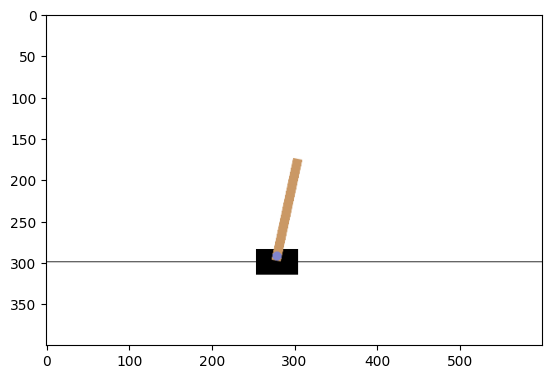

In [4]:
# 시뮬레이션 결과를 시각화합니다.
visualize_render_queue(render_queue)

랜덤한 행동을 수행했을 때 막대기가 바로 쓰러지는 것을 확인할 수 있습니다. 이제 Deep Q-Network를 구현하여 CartPole 환경에서 학습을 진행해보겠습니다.

## 2. Deep Q-Network 학습 구성 요소 구현

Deep Q-Network 학습 알고리즘의 핵심 구성요소는 다음과 같습니다.
1. Q 함수, Target Q 함수
2. 목표함수
3. Replay Buffer

Deep Q-Network 학습 알고리즘은 다음과 같은 순서로 진행됩니다.
1. 환경에서 입력 받은 상태 $x_t$를 전처리하여 전처리한 상태 $s_t$ 로 변환한다.
2. Q 함수에 전처리한 상태 $s_t$를 입력하고, 생성한 행동 $𝑎_𝑡$를 환경에 입력한다.
3. 환경이 다음 상태 $x_{t+1}$과 보상 $r_t$, 완료 여부 $d_t$를 반환한다. 
4. 반환된 $x_{t+1}$를 전처리하여 전처리한 상태 $s_{t+1}$으로 변환하고, $(s_t,a_t,r_t,s_{t+1},d_t)$ 을 Replay Buffer에 저장한다.
5. Replay Buffer에 충분한 데이터가 없다면, 충분한 데이터가 모일 때 까지 1~4를 반복한다.<br><br>
6. Replay Buffer에서 $D$개의 데이터를 랜덤하게 선택하여 Q 함수와 Target Q 함수에 입력한다.
7. 목표함수를 기반으로 신경망 $\theta$를 학습시킨다.
   1. 목표함수에 대해선 목표함수를 구현하는 부분에서 설명하겠습니다.
8. 1번으로 돌아간다.
9.  일정 주기 $C$ 마다 Target Q 함수의 신경망 $\theta^-$의 값을 Q 함수의 신경망 $\theta$의 값으로 업데이트 한다.
---

1번에서 상태 $x_t$ 를 전처리하는 과정은 환경, 문제, 목표 등에 따라 다양한 알고리즘을 활용합니다. 

예시로, Deep Q-Network를 처음 발표한 논문에서는 Atari 게임의 비디오 화면을 $x_t$ 로 정의하고, 화면을 회색조로 바꾼 후 현재 프레임과 이전 3프레임의 화면을 겹치는 전처리를 적용한 데이터를 상태 $s_t$ 로 사용했습니다.

이번 실습에서는 상태 $x_t$ 와 이전 3프레임의 상태 $x_{t-3}, x_{t-2}, x_{t-1}$ 를 이어붙인 값을 전처리한 상태 $s_t$ 로 사용하겠습니다. 

이론 강의에서 설명한 방법으로 Atari 게임에 DQN을 적용하는 실습은 [미션1] 에서 진행할 수 있습니다.

### 2-1. State 전처리 구현
상태 $x_t$ 를 전처리하여 전처리한 상태 $s_t$ 로 변환하는 class를 구현합니다.
현재 프레임을 포함한 4프레임의 데이터를 이어붙인 값을 전처리한 상태 $s_t$ 로 사용합니다.

4프레임의 값을 이어붙이는 이유는, 시간축 방향으로의 정보를 추가하기 위함입니다. (가속도 정보 등)

In [5]:
class StateManager:
    def __init__(self, window_size):
        self.window_size = window_size
        # 버퍼를 초기화 합니다. deque(데크, 덱)는 maxlen을 설정하여 버퍼의 크기를 제한할 수 있습니다.
        self.buffer = deque(maxlen=window_size)
        self.empty = True
    
    def add_raw_state(self, raw_state):
        # 전처리하지 않은 상태 x_t를 버퍼에 추가합니다.
        if self.empty:
            # 버퍼가 비어 있다면, 초기 상태로 가득 채웁니다.
            self.empty = False      
            self.buffer.extend([raw_state] * self.window_size)
        else:
            # 최대 길이를 넘을 경우, 가장 오래된 상태를 제거합니다.
            self.buffer.append(raw_state)
    
    def get_state_vector(self):
        # 4프레임의 데이터를 이어 붙인 상태를 PyTorch 모델에 입력할 수 있는 형태로 전처리합니다.
        state = np.concatenate(self.buffer, axis=0)
        state_vector = torch.FloatTensor(state)

        # 전처리한 상태 s_t를 반환합니다.
        return state_vector
    
    def reset(self):
        self.buffer.clear()
        self.empty = True

### 2-2. Replay Buffer 구현

Replay Buffer는 DQN 학습에서 데이터를 저장하고 출력하는 데이터 저장소이며, 아래 두가지 기능을 수행할 수 있어야 합니다.
- $(s_t,a_t,r_t,s_{t+1},d_{t+1})$ 을 Replay Buffer에 저장한다.
- 랜덤한 $D$ 개의 데이터를 선택하여 반환한다.

여기서 $d_{t+1}$는 에피소드가 종료되었는지 여부를 나타내는 값입니다. 논문에는 이 변수가 없지만, 에피소드가 종료되었을 때 예상 Q 값을 계산하는 식이 달라지기 떄문에 이를 구분하기 위해서 사용합니다.

수식은 2-4. Agent 구현 챕터에서 살펴보겠습니다.

In [6]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.max_size = max_size
        # 버퍼를 초기화 합니다. deque(데크, 덱)는 maxlen을 설정하여 버퍼의 크기를 제한할 수 있습니다.
        self.buffer = deque(maxlen=max_size)
        
    def memorize(self, element):
        # (s_t, a_t, r_t, s_{t+1}, d_t) 를 버퍼에 저장합니다.
        self.buffer.append(element)
        
    def sample(self, batch_size):
        # 랜덤한 D개 (batch_size)의 데이터를 샘플링하여 반환합니다.
        return random.sample(self.buffer, batch_size)

### 2-3. Deep Q-Network 구현
아래 이미지의 구조를 따르는 Deep Q-Network를 구현합니다. <br><br>

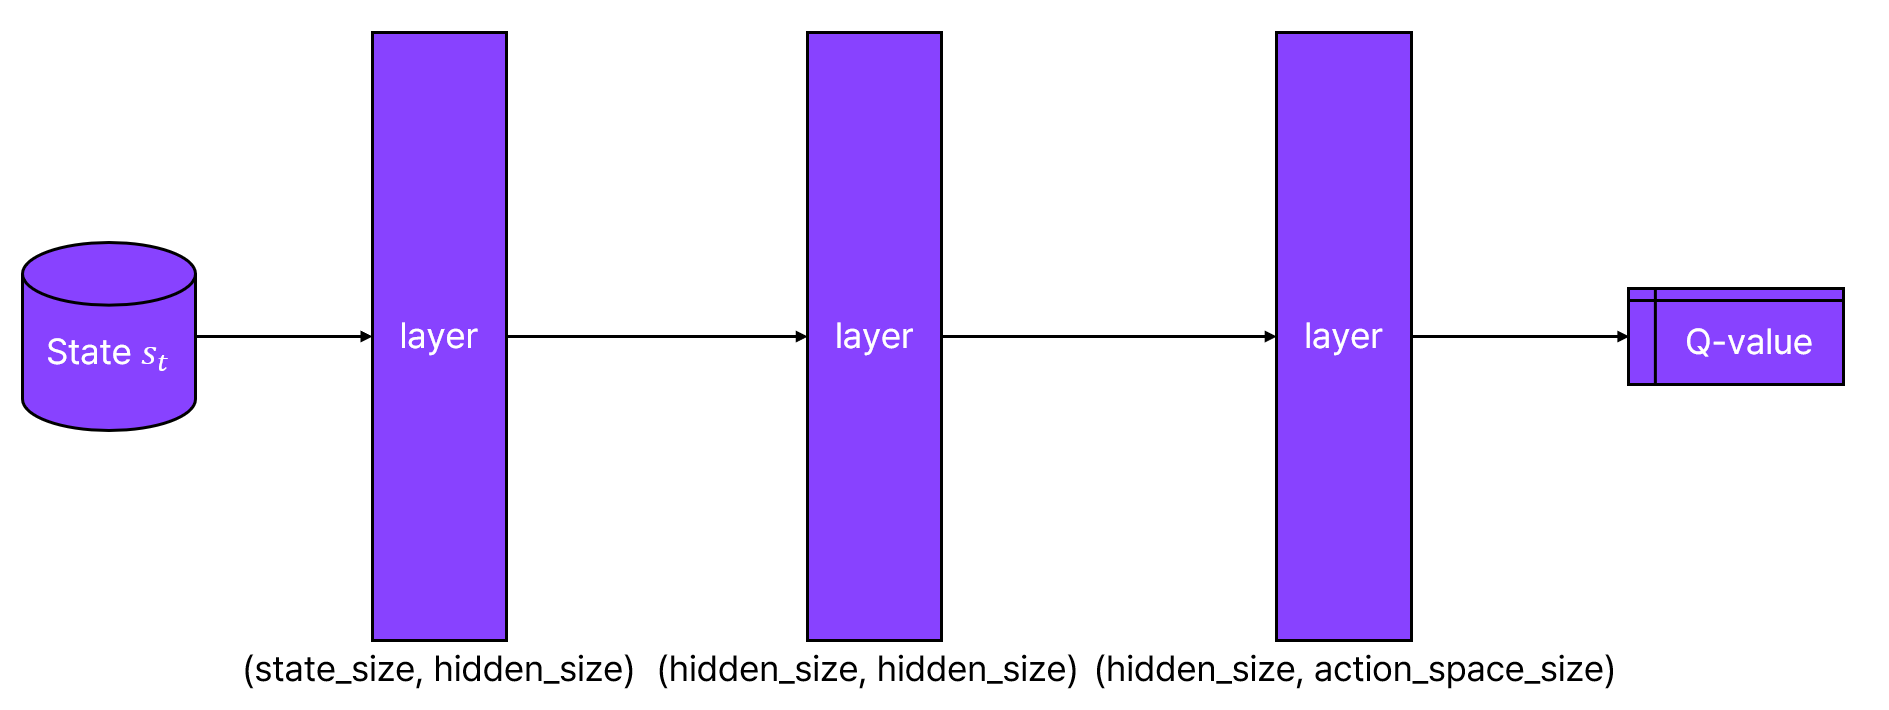

In [7]:
class QNet(nn.Module):
    def __init__(self, state_size, hidden_size, action_space_size):
        super(QNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_space_size)
        )
    
    def forward(self, x):
        # x는 각 행동에 대한 Q-value를 반환합니다.
        x = self.model(x)
        return x
    
    def save_model(self, path):
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        self.load_state_dict(torch.load(path))

### 2-4. Agent 구현
마지막으로, DQN을 적용한 Agent를 구현해 보겠습니다.

#### [TODO] 주석의 설명을 따라 Q-Network를 학습 시키는 `train` 메서드를 완성해주세요.
`train` 메서드는 DQN 알고리즘 중 6, 7번 과정을 수행합니다.

6. Replay Buffer에서 $D$개의 데이터를 랜덤하게 샘플링하여 Q 함수와 Target Q 함수에 입력한다.
7. 목표함수를 기반으로 신경망 $\theta$를 학습시킨다.

목표 함수$J_t(\theta)$는 아래와 같이 정의됩니다.
$$
J_t(\theta) = \mathbb{E}\left[ \left( R_t - Q(s_t, a_t; \theta) \right)^2\right] \text{ where } R_t = \begin{cases} r_t & \text{if episode continues} \\ r_t + \gamma \max_{a_{t+1}} \hat{Q}(s_{t+1}, a_{t+1}; \theta^-) & \text{if episode ends} \end{cases}
$$
$\gamma$는 감가율, $\theta$는 Q 함수의 신경망(파라미터), $\theta^-$는 Target Q 함수의 신경망(파라미터)를 의미합니다. <br><br>
$R_t$ 는 Episode가 종료되었을 때는 현재 보상, 종료되지 않았을 때는 현재 보상과 다음 상태에서의 Target Q 함수로 계산한 최대 Q값을 합한 값입니다.

In [8]:
class DQNAgent():
    def __init__(self, buffer_size, batch_size, gamma, qnet, target_qnet, optimizer, epsilon=1.0, epsilon_decay=0.999, epsilon_min=0.01):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.qnet = qnet
        self.target_qnet = target_qnet
        self.optimizer = optimizer
        self.buffer = ReplayBuffer(buffer_size)
        self.loss_fn = nn.MSELoss()

        self.init_epsilon = epsilon
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.reset()

    def memorize(self, element):
        self.buffer.memorize(element)

    def add_raw_state(self, raw_state):
        self.state_manager.add_raw_state(raw_state)

    def act(self, exploration=True):
        if exploration and random.random() < self.epsilon:
            return env.action_space.sample()
        else:
            state_vector = self.state_manager.get_state_vector()
            with torch.no_grad():
                return np.argmax(self.qnet(state_vector).detach().numpy())
    
    def get_current_state(self):
        return self.state_manager.get_state_vector()

    def update_qnet(self):
        self.target_qnet.load_state_dict(self.qnet.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * (1 - self.epsilon_decay))

    def reset_epsilon(self):
        self.epsilon = self.init_epsilon

    def reset_state_manager(self):
        self.state_manager = StateManager(4)
    
    def reset(self):
        self.reset_epsilon()
        self.reset_state_manager()
    
    def train(self):
        if len(self.buffer.buffer) < self.batch_size:
            return -1
        
        # TODO: [지시사항 1A] 버퍼에서 랜덤한 self.batch_size 만큼의 데이터를 샘플링합니다.
        # Hint. ReplayBuffer 클래스의 sample 메서드를 사용합니다.
        batch = self.buffer.sample(self.batch_size)
        state_batch, action_batch, reward_batch, next_state_batch, done_mask = zip(*batch) 

        # 각 데이터를 PyTorch Tensor로 변환합니다.
        state_batch = torch.stack(state_batch)
        next_state_batch = torch.stack(next_state_batch)

        reward_batch = torch.tensor(reward_batch)
        action_batch = torch.tensor(action_batch)
        done_mask = torch.tensor(done_mask)

        # 현재 상태의 Q-value를 계산합니다.
        q_values = self.qnet(state_batch)
        # Target Q-Network를 통해 다음 상태의 Q-value를 계산합니다.
        next_q_values = self.target_qnet(next_state_batch)
        q_value = q_values.gather(1, action_batch.unsqueeze(-1)).squeeze(-1)
        next_q_value = next_q_values.max(1).values
        
        # TODO: [지시사항 1B] Q-value를 업데이트하기 위한 예상 Q 값을 계산합니다.
        # Hint. 현재 상태가 종결 상태가 아닐 때 예상 Q-value는 현재 보상 + (감가율 * Target Q-Network를 통해 예측한 다음 상태의 Q 값)입니다.
        future_q_value = self.gamma * next_q_value # None 를 채워주세요.
        # 현재 상태가 종결 상태라면 미래에 받을 것으로 예상되는 Q-Value는 0입니다.
        future_q_value = future_q_value * ~done_mask

        expected_q_value = reward_batch + future_q_value # None 를 채워주세요.

        loss = self.loss_fn(q_value, expected_q_value)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()
    
    def save_model(self, path):
        self.qnet.save_model(path)

    def load_model(self, path):
        self.qnet.load_model(path)
        self.target_qnet.load_model(path)

## 3. Train 함수 구현

아래 Deep Q-Network 학습 알고리즘을 따라 학습을 진행하는 Train 함수를 구현합니다.
1. 환경에서 입력 받은 상태 $x_t$를 전처리하여 전처리한 상태 $s_t$ 로 변환한다.
2. Q 함수에 전처리한 상태 $s_t$를 입력하고, 생성한 행동 $𝑎_𝑡$를 환경에 입력한다.
3. 환경이 다음 상태 $x_{t+1}$과 보상 $r_t$, 완료 여부 $d_t$를 반환한다. 
4. 반환된 $x_{t+1}$를 전처리하여 전처리한 상태 $s_{t+1}$으로 변환하고, $(s_t,a_t,r_t,s_{t+1},d_{t+1})$ 을 Replay Buffer에 저장한다.
   1. 논문의 알고리즘에는 $d_{t+1}$ 변수가 없지만, 구현 과정에서는 에피소드가 종료되었는지 여부를 나타내는 $d_t$를 저장해야 합니다.
5. Replay Buffer에 충분한 데이터가 없다면, 충분한 데이터가 모일 때 까지 1~4를 반복한다.<br><br>
6. Replay Buffer에서 $D$개의 데이터를 랜덤하게 선택하여 Q 함수와 Target Q 함수에 입력한다.
7. 목표함수를 기반으로 신경망 $\theta$를 학습시킨다.
8. 1번으로 돌아간다.
10. 일정 주기 $C$ 마다 Target Q 함수의 신경망 $\theta^-$의 값을 Q 함수의 신경망 $\theta$의 값으로 업데이트 한다.

#### [TODO] 주석의 설명을 따라 위 알고리즘을 구현한 `train` 함수를 완성해주세요.

In [9]:
def train(env, agent, max_step = 100000, max_step_per_episode = 5000, min_buffer_size=500, target_update_interval=10, save_path = None):
    # 학습 과정을 출력하기 위한 tqdm을 설정합니다.
    repeater = tqdm(range(max_step), desc="Step")
    repeater.set_description("Episode - {}".format(0))

    agent.reset()

    done = False

    cur_ep_step = 0
    episode_count = 0
    loss_list = []
    reward_list = []
    reward_sum = 0
    max_reward = -1

    # Step 1-1. 환경에서 초기 상태를 얻습니다.
    cur_raw_state = env.reset()[0]

    # Step 1-2. 상태를 StateManager에 추가합니다. StateManager는 데이터를 내부에서 전처리합니다.
    agent.add_raw_state(cur_raw_state)
    
    for step in repeater:
        cur_ep_step += 1

        # Step 1-3. 전처리된 상태 s_t를 얻습니다.
        state = agent.get_current_state()

        # Step 2-1. Q 함수에 전처리된 상태 s_t를 입력하고, 생성된 행동 a_t를 action 변수에 저장합니다.
        action = agent.act(exploration=True)

        # TODO: [지시사항 2A] 생성된 행동을 환경에 적용하고, 환경이 반환하는 상태 x_{t+1}, 보상 r_t, 종료 여부 d_t를 저장하는 코드를 작성해주세요.
        # Step 2-2. 생성된 행동 a_t를 환경에 적용합니다.
        # Step 3. 환경이 다음 상태 x_{t+1}, 보상 r_t, 종료 여부 d_t를 반환합니다.
        # Hint. 환경이 어떤 값을 리턴하는지는 노트북 상단의 1. CartPole 시뮬레이션 환경 챕터의 코드를 참고해주세요.
        next_raw_state, reward, done, _, _ = env.step(action)
        reward_sum += reward

        # TODO: [지시사항 2B] Step 4-1. 반환된 x_{t+1} 를 StateManager에 추가하여 전처리된 상태 s_{t+1} 을 얻는 코드를 작성해주세요.
        # Hint. agent.add_raw_state() 메서드와 agent.get_current_state() 메서드를 활용할 수 있습니다.
        agent.add_raw_state(next_raw_state)
        next_state = agent.get_current_state()

        # TODO: [지시사항 2C] Step 4-2. (s_t,a_t,r_t,s_{t+1},d_t) 5-tuple을 Replay Buffer에 저장하는 코드를 작성해주세요.
        element = (state, action, reward, next_state, done)
        agent.memorize(element)

        # Epsilon-Greedy 정책의 epsilon 값을 업데이트합니다.
        agent.decay_epsilon()
        
        # Step 5. Replay Buffer에 충분한 데이터가 없다면, 충분한 데이터가 모일 때 까지 1~4를 반복합니다.
        if step > min_buffer_size:
            # Step 6, 7. 충분한 데이터가 있다면, 6, 7번째 과정을 거쳐 Q-Network를 학습합니다.
            loss = agent.train()
            loss_list.append(loss)
        
        # Step 9. Target Q-Network를 일정한 주기로 업데이트합니다.
        if step % target_update_interval == 0:
            agent.update_qnet()
        
        # 에피소드가 종료되면, 다음 에피소드를 준비합니다.
        if done or cur_ep_step > max_step_per_episode:
            # StateManager를 초기화 합니다. (이전 episode의 상태를 버립니다. 메모리는 초기화하지 않습니다)
            agent.reset_state_manager()

            # 환경을 초기화하여 상태 x_0 을 얻습니다.
            cur_raw_state = env.reset()[0]
            agent.add_raw_state(cur_raw_state)
            
            # 현재 Episode의 정보를 출력합니다.
            episode_count += 1
            cur_ep_step = 0
            repeater.set_description("Episode - {}, Total Reward - {}".format(episode_count, reward_sum))

            # Reward가 가장 높은 모델을 저장합니다.
            # 저장한 모델을 활용해서 채점을 하기 때문에 이 코드는 수정하지 말아주세요!
            if max_reward < reward_sum:
                max_reward = reward_sum
                # 여기 있는 None은 수정하지 말아주세요!
                if save_path is not None:
                    agent.save_model(save_path + "/best_model.pt")

            reward_list.append(reward_sum)
            reward_sum = 0
            done = False
                
    return loss_list, reward_list

## 4. 학습 진행

하이퍼파라미터를 설정하고, 학습을 진행합니다. 학습에는 약 3분이 소요됩니다.

In [10]:
# Deep Q Network 구조 관련 하이퍼파라미터를 설정합니다.
hidden_size = 64

# Deep Q Network의 최적화 함수의 학습율을 설정합니다.
learning_rate = 1e-4

# Replay Buffer의 크기를 설정합니다.
buffer_size = 10000

# 감가율
gamma = 0.99

# 학습 알고리즘의 하이퍼파라미터를 설정합니다.
batch_size = 32 # 한 번에 Replay Buffer에서 샘플링할 데이터의 수
max_step = 100000 # 총 학습할 step 수
max_step_per_episode = 500 # 한 Episode 별 최대 step 수
target_update_interval = 100 # Target Q-Network를 업데이트할 step의 간격
min_buffer_size = 500 # Replay Buffer에 최소한으로 저장되어야 하는 데이터의 수

# Epsilon-greedy 정책을 위한 하이퍼파라미터를 설정합니다.
epsilon = 1.0
epsilon_decay = 0.001
epsilon_min = 0.01

Q 함수와 Agent, optimizer를 초기화 합니다.

In [11]:
qnet = QNet(16, hidden_size=hidden_size, action_space_size=env.action_space.n) # Q 함수를 생성합니다
target_qnet = QNet(16, hidden_size=hidden_size, action_space_size=env.action_space.n) # Target Q 함수를 생성합니다
target_qnet.load_state_dict(qnet.state_dict()) # Target Q 함수의 신경망을 Q 함수의 신경망으로 대체합니다.

optimizer = torch.optim.Adam(qnet.parameters(), lr=learning_rate) # Q 함수를 학습시킬 최적화 함수를 설정합니다.

agent = DQNAgent(buffer_size=buffer_size,
                 batch_size=batch_size,
                 gamma = gamma,
                 qnet=qnet,
                 target_qnet=target_qnet,
                 optimizer=optimizer,
                 epsilon=epsilon,
                 epsilon_decay=epsilon_decay,
                 epsilon_min=epsilon_min) # Q 함수와 Target Q 함수를 이용하여 DQNAgent를 생성합니다.

학습을 진행합니다.

In [12]:
import os

if not os.path.exists("ckpt"):
    os.makedirs("ckpt")

loss_log, reward_log = train(env,
                             agent,
                             max_step=max_step,
                             max_step_per_episode=max_step_per_episode,
                             min_buffer_size=min_buffer_size,
                             target_update_interval=target_update_interval,
                             save_path="ckpt")

Episode - 955, Total Reward - 501.0: 100%|██████████| 100000/100000 [02:37<00:00, 635.76it/s]


## 6. 학습 결과 시각화

학습이 종료되었으면, 결과를 시각화 해보겠습니다.

먼저 학습 과정의 Loss 값을 시각화 해보겠습니다. 이때 50 step의 평균 Loss 값을 시각화합니다.

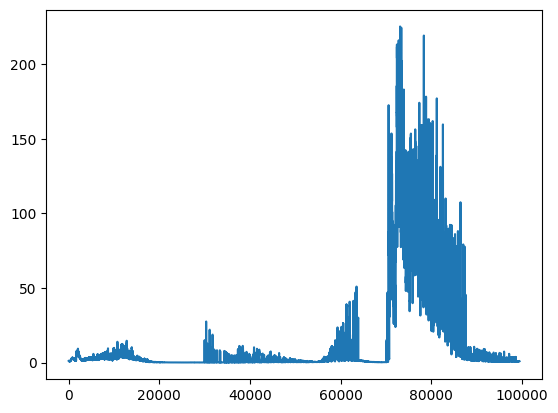

In [13]:
# plot rolling avg of loss
def rolling_avg(data, window_size=50):
    return [np.mean(data[i:i+window_size]) for i in range(len(data) - window_size)]

plt.plot(rolling_avg(loss_log))

다음으로, 매 episode 별 Reward를 시각화 해보겠습니다.

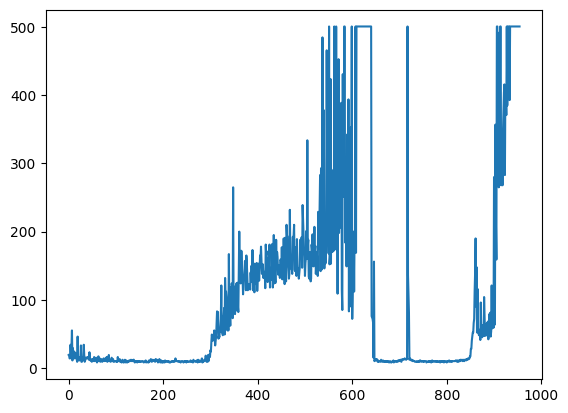

In [14]:
plt.plot(reward_log)

어느 시점 이후로 Reward가 급격히 증가하는 것을 확인할 수 있습니다.

다음으로, Best Model을 불러와 CartPole 환경에서 테스트를 진행해보겠습니다.

In [15]:
# 학습된 에이전트를 시각화합니다.
# 환경을 초기화한 후 초기 상태를 시각화합니다.
env = gym.make('CartPole-v1', render_mode='rgb_array')
raw_state = env.reset()[0]
render_queue = []
agent.load_model("ckpt/best_model.pt")
agent.reset_state_manager()
done = False

while done == False:
    render_queue.append(env.render())
    agent.add_raw_state(raw_state)
    action = agent.act(exploration=False)
    next_state, reward, done, _, _ = env.step(action)
    raw_state = next_state
            
env.close()

테스트 결과를 시각화합니다.

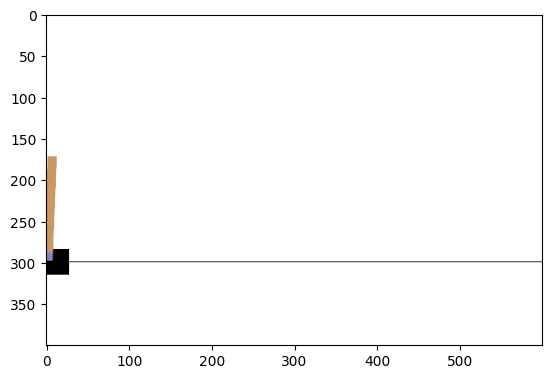

In [16]:
# 시각화 및 결과 저장
visualize_render_queue(render_queue)

### 결과 제출

- 학습 과정에서 제일 Reward가 높은 모델은 `ckpt/best_model.pt` 로 저장되었습니다.
- 아래 코드를 실행하여 여러분이 사용하신 하이퍼파라미터를 파일로 저장해주세요.

In [17]:
# 여러분이 학습 과정에서 사용하신 하이퍼파라미터를 저장합니다.
import json

hyperparameters = {
    "hidden_size": hidden_size,
    "learning_rate": learning_rate,
    "buffer_size": buffer_size,
    "gamma": gamma,
    "batch_size": batch_size,
    "max_step": max_step,
    "max_step_per_episode": max_step_per_episode,
    "target_update_interval": target_update_interval,
    "min_buffer_size": min_buffer_size,
    "epsilon": epsilon,
    "epsilon_decay": epsilon_decay,
    "epsilon_min": epsilon_min
}

with open("ckpt/hyperparameters.json", "w") as f:
    json.dump(hyperparameters, f)

- 파일 저장이 완료되었으면 우측 상단에 있는 보라색 `제출` 버튼을 눌러 모델 파일을 제출해주세요.
- 채점 환경에서 Agent가 300 step 이상 버티면 성공입니다.
- 5번 시도한 후 한번도 성공하지 못하면 실패로 간주합니다.

### 